# DQN Learning - Lunar Lander
DJ Swanevelder


Date: 2025-05-29

This is a my version of the 3rd coursework for Reinforcement Learning and Planning, as part of my master's Degree in Machine Learning and AI at stellenbosch university. The goal of the project is to implenet DQN Learning on the lunar lander.   

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import numpy as np
import numpy.random as random
import gymnasium as gym
import mediapy as media
import matplotlib.pyplot as plt
from IPython.display import clear_output
import csv

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## DQN Set Up

### DQN Description

A basic Deep Q-Network (DQN) implementation requires the following components:

### 1. Neural Networks (Main & Target)

A neural network class `DQN` is used for both the main Q-network and the target Q-network. The architecture includes:

- Two hidden layers of width `size` (default 24)
- ReLU activations for non-linearity
- Xavier weight initialisation for stable learning

### 2. Replay Buffer

A `ReplayBuffer` class to store and sample experiences efficiently:

- **Initialisation**: Create a fixed-size buffer with a defined capacity  
- **Add**: Insert new experiences as `(state, action, reward, next_state, done)`  
- **Remove**: Automatically discards the oldest experiences when full (via `deque`)  
- **Sample**: Randomly sample a mini-batch of experiences for training  
- **Length**: Returns the current number of stored experiences  

### 3. Agent

The `DQNAgent` class manages environment interaction, learning, and training. It includes the following components:

#### Initialisation
- Creates the Gym environment
- Instantiates a replay buffer
- Sets training hyperparameters (e.g. gamma, epsilon, learning rate)
- Builds the main and target Q-networks

#### Action Selection (Epsilon-Greedy)
- Chooses a random action with probability `epsilon`
- Otherwise selects the greedy action: `argmax(Q(s))` from the main Q-network

#### Epsilon Decay
- Epsilon decays exponentially from a maximum to minimum value after a warmup phase
- Controlled by a `decay_rate` parameter

#### Q-Network Update
- Samples a batch of experiences from the replay buffer
- Computes the target values using the Bellman equation
- Calculates loss between current Q-values and targets (MSE)
- Performs backpropagation and optimiser step

#### Target Network Update
- Every `target_update_freq` episodes, copies the main network's weights to the target network
- Helps stabilise training

#### Training Loop
- Iterates over a number of episodes
  - At each time step:
    - Selects an action using epsilon-greedy policy
    - Steps through the environment
    - Stores the transition in the replay buffer
    - Updates the Q-network
  - Updates the target network periodically
  - Logs episode reward

#### Saving the Model
- Stores the trained Q-network weights to a `.pth` file for later use

#### Plotting
- If enabled, displays live plots of:
  - Episode rewards
  - Epsilon values across training

    


### Neural Network

In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim,size = 24):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim,size)   # First hidden layer with 24 neurons
        self.fc2 = nn.Linear(size, size)          # Second hidden layer with 24 neurons
        self.out = nn.Linear(size, output_dim)  # Output layer with one neuron per action
        self.apply(self.init_weights)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        return self.out(x)
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

### Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        """
        Fixed-size buffer that stores experience tuples (s, a, r, s') for training.

        Parameters:
        - capacity (int): Maximum number of experiences the buffer can hold.
        """
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state,done):
        """
        Add a new experience to the buffer.

        Parameters:
        - state (array-like): Current state.
        - action (int): Action taken.
        - reward (float): Reward received.
        - next_state (array-like): Resulting state after taking action.
        """
        self.buffer.append((state, action, reward, next_state,done))

    def sample(self, batch_size):
        """
        Randomly sample a batch of experiences from the buffer.

        Parameters:
        - batch_size (int): Number of experiences to sample.

        Returns:
        - list of tuples: Sampled (state, action, reward, next_state) experiences.
        """
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        return [self.buffer[i] for i in indices]
    def __len__(self):
        return len(self.buffer)  # assuming self.buffer is the internal storage list or deque

### DQN Agent

In [4]:
class DQNAgent:
    def __init__(self,             
                episodes,
                gamma,
                epsilon_max,
                epsilon_min,
                decay_rate,
                batch_size,
                target_update_freq,
                learn_rate,
                buffer_capacity,
                path="lunar_lander.pth",
                plot = False,
                size = 24):
        
        self.eps = episodes
        self.gamma = gamma
        self.e_max = epsilon_max
        self.e_min = epsilon_min
        self.decay= decay_rate
        self.batch_size = batch_size
        self.target_freq = target_update_freq
        self.path = path
        self.epsilon = epsilon_max

        self.plot = plot
        self.rewards = []
        self.epsilons = []

        # Create objects for DQN, Env, Networks, Replay Buffer, Optimizer
        self.env = gym.make("LunarLander-v3")
        self.env.reset(seed=42)

        self.main_Q = DQN(self.env.observation_space.shape[0], self.env.action_space.n,size=size)

        self.target_Q = DQN(self.env.observation_space.shape[0], self.env.action_space.n,size=size)
        self.target_Q.load_state_dict(self.main_Q.state_dict())
        self.target_Q.eval()

        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)
        self.optimizer = torch.optim.Adam(self.main_Q.parameters(), lr=learn_rate)

    def decay_epsilon(self, episode):
        if episode >150:
            self.epsilon  = max(self.e_min, self.e_max * np.exp(-self.decay * (episode-150)))
        else:
            self.epsilon = self.e_max
        self.epsilons.append(self.epsilon)

    def select_action(self, state):
        u = random.uniform()
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        if u < self.epsilon:
            a = torch.randint(0, self.env.action_space.n, (1,)).item()
        else:
            with torch.no_grad():
                Q_values = self.main_Q(state_tensor)
                a = int(torch.argmax(Q_values).item())
                # print(f'u:{u} action:{a}')
        
        return a
            
    def update_Q(self,step):
        if len(self.replay_buffer) < self.batch_size:
            return 
        if step % 4 != 0:
            return
            
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        with torch.no_grad():
            target_Q_values = self.target_Q(next_states)
            max_target_Q, _ = target_Q_values.max(dim=1, keepdim=True)
            targets = rewards + self.gamma * max_target_Q * (1 - dones)

        main_Q_values = self.main_Q(states)
        selected_Q = main_Q_values.gather(1, actions)
        loss = F.mse_loss(selected_Q, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self,episode):
        if episode % self.target_freq == 0 :
            self.target_Q.load_state_dict(self.main_Q.state_dict()) # Hard update
            self.target_Q.eval()
        
            if self.plot: self.plot_rewards(self.rewards)

    def train(self):
        state, _ = self.env.reset(seed=42)

        for ep in range(self.eps):

            total_reward = 0
            state, _ = self.env.reset()
            done = False

            self.decay_epsilon(ep)

            step = 0
            while not done:

                action = self.select_action(state)
                
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                self.replay_buffer.add(state, action, reward, next_state, done)
                total_reward += reward
                
                self.update_Q(step)

                state = next_state
                step += 1
            
            self.update_target_network(ep)
            self.rewards.append(total_reward)
            
        self.save_QNN()
        self.env.close()
        
    def save_QNN(self):
        torch.save(self.main_Q.state_dict(), self.path)
        print(f"\nTrained Q-Network saved to {self.path}")
            
    def plot_rewards(self, rewards):
        clear_output(wait=True)
        fig, ax1 = plt.subplots(figsize=(10, 6))

        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Reward", color="tab:blue")
        ax1.plot(rewards, label="Rewards", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        ax2 = ax1.twinx()
        ax2.set_ylabel("Epsilon", color="tab:red")
        ax2.plot(self.epsilons, label="Epsilon", color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        fig.tight_layout()
        plt.title("Rewards and Epsilon Over Episodes")
        plt.grid(True)
        plt.show()

## Training

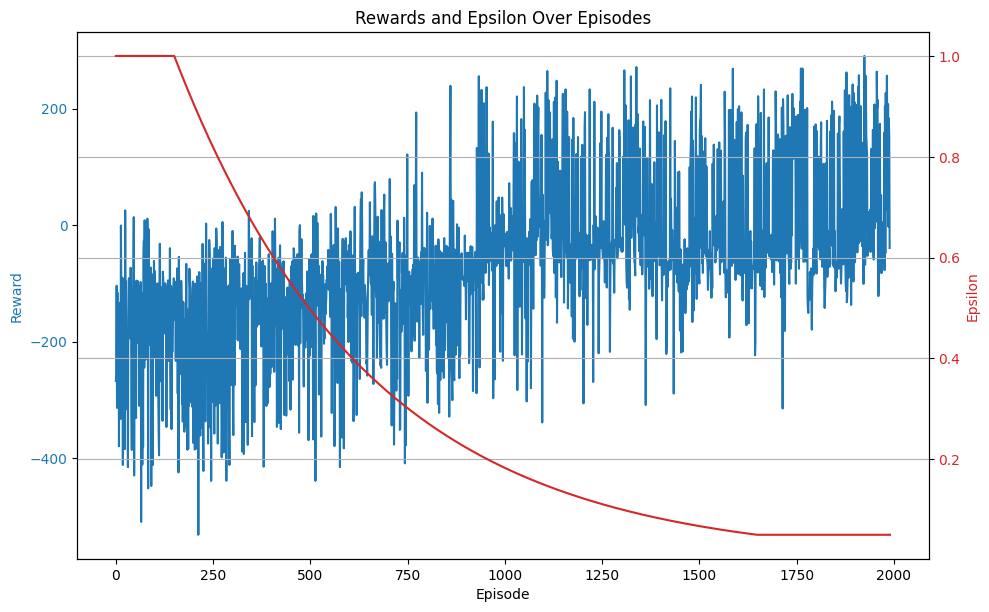


Trained Q-Network saved to lunar_lander_test.pth


In [ ]:
param = {
    'episodes': 2000,
    'gamma': 0.99, 
    'epsilon_max': 1.0,
    'epsilon_min': 0.05, 
    'decay_rate': 0.002, 
    'batch_size': 128, 
    'target_update_freq': 10,
    'learn_rate': 1E-4,
    'size': 20,
    'buffer_capacity': 1000,
    'plot': True
}

agent = DQNAgent(**param,path=f"models/lunar_lander_test.pth")
agent.train()
rewards = agent.rewards


## Testing

In [6]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env.reset(seed=42)

main_Q = DQN(env.observation_space.shape[0], env.action_space.n,size=20)
main_Q.load_state_dict(torch.load("models/lunar_lander_0.pth"))
main_Q.eval()

def test_trained_policy(env, main_Q, render_fps=10, tests = 100):

    best_reward = 0
    best_frames = []
    rewards = []

    for _ in range(tests):
        state, _ = env.reset()
        done = False
        frames = []
        total_reward = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                Q_values = main_Q(state_tensor)
            action = int(torch.argmax(Q_values).item())

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward

            frame = env.render()
            if frame is not None:
                frames.append(frame)


        rewards.append(total_reward)
        if total_reward > best_reward:
            best_reward = total_reward
            best_frames = frames

    env.close()


    # Show video of best run
    if best_frames: 
        media.show_video(best_frames, fps=render_fps)
    else:
        print("No frames captured. Check render_mode and rendering logic.")

    print(f'Best reward: {best_reward}')
    print(f'Mean reward: {np.mean(rewards)} out of {tests}  tests')
    
    return rewards

rewards = test_trained_policy(env, main_Q, render_fps=10, tests=10)

Best reward: 281.41486335619936
Mean reward: 202.1255259367453 out of 10  tests


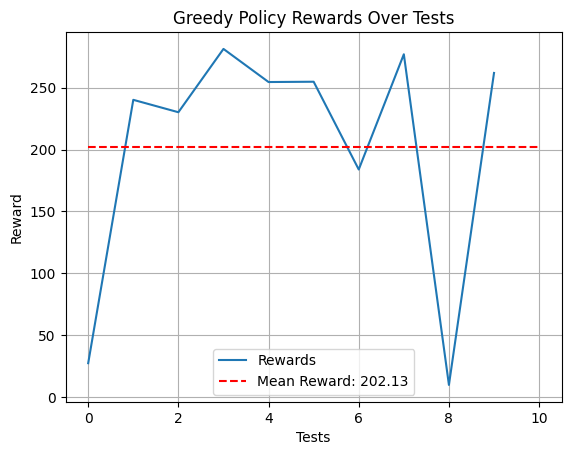

In [7]:
plt.plot(rewards, label="Rewards", color="tab:blue")
plt.xlabel("Tests")
plt.ylabel("Reward")
plt.hlines(np.mean(rewards), 0, len(rewards), colors='r', linestyles='dashed', label=f'Mean Reward: {np.mean(rewards):.2f}')
plt.title("Greedy Policy Rewards Over Tests")
plt.legend()
plt.grid()
plt.show()

## References
- Code assistance via ChatGPT  
- [Gymnasium](https://www.farama.org/Gymnasium/) reinforcement learning library  
- PyTorch CartPole [example](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) implementation
